In [1]:
%pylab inline

import seaborn as sns
sns.set_style('white')

import pandas as pd

import torch
import torch.nn as nn

from code.data.cmnist_dist import make_joint_distribution
from code.discrete_distributions import DiscreteDistribution, compute_ce, compute_kl
from code.discrete_distributions.plot import plot_data
from code.discrete_models.training import train
from code.discrete_models.encoders import DiscreteEncoder

Populating the interactive namespace from numpy and matplotlib


# Data distribution

We will use the y-CMNIST data distribution as an example in this notebook, which defines a joint distribution of digits $d$, color $c$, pictures $x$, environments $e$, labels $y$ and selection $t$.
The binary selection variable $t$ indicates if the data is selected for training $t=1$ or not $t=0$.

Joint distribution: p(y,e,d,x,c,t)


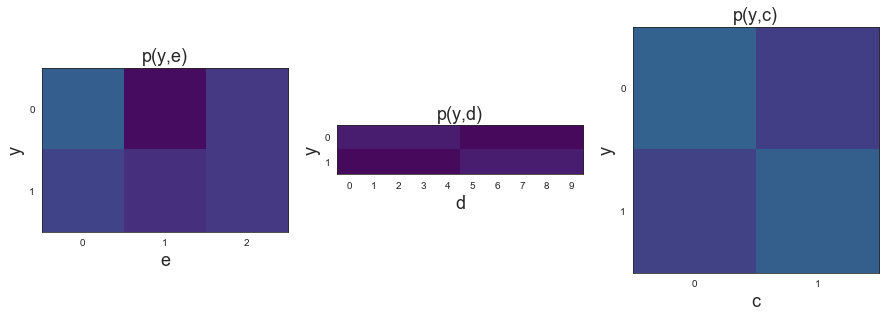

In [2]:
# Create the joint distribution for y-CMNIST (CMNIST or d-CMNIST are also available)
dataset = 'y-CMNIST'
dist = make_joint_distribution(dataset)

print('Joint distribution: %s' %dist)


# We visualize some of the pair-wise joint distributions
f, ax = plt.subplots(1,3, figsize=(15, 5))

for i, joint in enumerate([
    dist.marginal(['y','e']), 
    dist.marginal(['y','d']), 
    dist.marginal(['y','c'])]): 
    
    ax[i].set_title(joint, size=18)
    ax[i].imshow(joint.p, clim=(0,1), cmap='viridis')
    ax[i].set_xlabel(joint.indices[1], size=18)
    ax[i].set_ylabel(joint.indices[0], size=18)
    ax[i].set_xticks(range(joint.p.shape[1]))
    ax[i].set_yticks(range(joint.p.shape[0]))




The joint distribution factorizes as $p(y,e,d,x,c,t) = p(y|d)p(e)p(d)p(c|y,e)p(x|c,d)p(t|e)$.
Train and test distributions are created by conditioning on $t=1$ and $t=0$, respectively.

In [3]:
# Create the training distribution by selecting t=1
train_dist = dist.condition_on('t',1)

# Create the test distribution by selecting t=0
test_dist = dist.condition_on('t',0)

print('Train distribution: %s' %train_dist)
print('Test distribution: %s' %test_dist)

Train distribution: p(y,e,d,x,c|t=1)
Test distribution: p(y,e,d,x,c|t=0)


We can describe how distant the train and test distributions are by computing $I(xy;t)$, which represents how much information the selection carries about the joint distribution of raw features (pictures $s$) and targets (labels $y$). The distribution shift can be seen as the joint effect of covariate shift $I(t;x)$ and concept shift $I(y;t|x)$:

$$\underbrace{I(xy;t)}_{\text{distribution shift}} = \underbrace{I(x;t)}_{\text{covariate shift}} + \underbrace{I(y;t|x)}_{\text{concept shift}}$$

In [4]:
# Compute the amout of distribution shift I(xy;t)
print('Distribution shift: %f nats' %(dist.compute('I(x,y;t)')))

# Compute the amout of concept shift I(y;t|x)
print('Concept shift: %f nats' %(dist.compute('I(y;t|x)')))

# Compute the amout of concept shift I(x;t)
print('Covariate shift: %f nats' %(dist.compute('I(x;t)')))

Distribution shift: 0.306607 nats
Concept shift: 0.237813 nats
Covariate shift: 0.068793 nats


Note that the selection $t$ does induce concept shift, therefore a maximum likelihood solution must result in positive Test error.
Given a model $q(y|x)$ that is optimal on the training distribution $p(y|x,t=1)$ we have:
$$KL(p(y|x,t=0)||q(y|x))\ge \frac{1}{1-\alpha} I(y;t|x) > 0.237813 \text{ nats}$$

# Introducing a Latent representation

The test error for a model that is composed by an encoder $q(z|x)$ and classifier $q(y|z)$ is upper bounded by the $\textit{Test Information Loss}$, which represents the amount of information lost trhough the encoding procedure (in red), and $\textit{Latent Test error}$ (in blue) which represents the error when using the latent features $z$ instead of the original observations $x$:
$$\underbrace{KL(p(y|x,t=0)||q(y|x))}_{\text{Test Error}}\le \underbrace{I_{t=0}(x;y|z)}_{\text{Test Information Loss}} + \underbrace{KL(p(y|z,t=0)||q(y|z))}_{\text{Latent Test Error}}$$
Clearly, considering an identity encoder, which maps each observation into itself, the Test error is equivalent to the Latent Test error. This also happens for any encoder $q(z|x)$ that retains all the predictive information.

q(y|x)=p(y|x,t=1)
Lower-bound I(y;x|t): 0.356720 nats
OOD error: 1.249681 nats


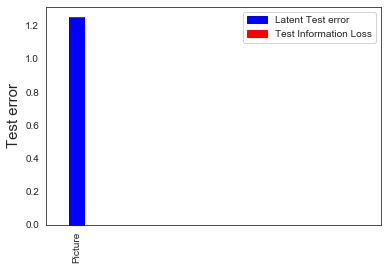

In [5]:
data = []

# define alpha as the minimum probability between p(t=0) and p(t=1)
alpha = dist.marginal('t').p.min()

# Consider a model q(y|x) that matches the train distribution p(y|x,t=1)
q_y_x = train_dist.conditional('y','x')
print('q(y|x)=%s' % q_y_x)

# Compute the lower bound I(y;t|x)/(1-alpha)
l_bound = dist.compute('I(y;t|x)')/(1-alpha)

# Compute the OOD error for q(y|x): KL(p(y|x,t=0)||q(y|x))
ood_error = compute_kl(test_dist, q_y_x)

print('Lower-bound I(y;x|t): %f nats' % l_bound)
print('OOD error: %f nats' % ood_error)

data.append({
    'Model': 'Picture',
    'Test Information Loss': 0,
    'Latent Test error': ood_error.item()
})

f, ax = plt.subplots(1,1)
plot_data(data, ax)

We compute and visualize the components of the Test error for models that build representations based on color $c$, digit $d$ or no information (prior). 

Since the two marginal label distributions $p(y|t=0)$ and $p(y|t=1)$ are equivalent, the error of a model that discards all the information is entirely due to information loss, and the corresponding Latent Test error is zero. 

On the other hand, any model that relies exclusively on color information (discarding anying about the digits) incurs in a higher Test error since the dependency between color and label is inverted at test time ($t=0$). 

A model that discards color information while keeping digit information is able to minimize the latent Test error, while retaining most of the predictive information. The corresponding representation contains only digit information which is reliable to predict the label $y$ across all the environments.

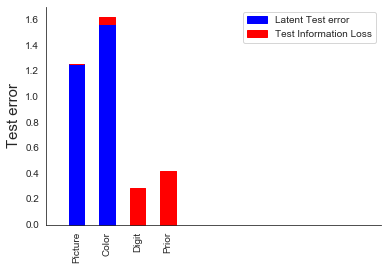

In [6]:
models = []

# Color
data.append({
    'Model': 'Color',
    'Latent Test error': compute_kl(test_dist, train_dist.conditional('y','c')),
    'Test Information Loss': test_dist.mi('y','x','c')
})

# Digit
data.append({
    'Model': 'Digit',
    'Latent Test error': compute_kl(test_dist, train_dist.conditional('y','d')),
    'Test Information Loss': test_dist.mi('y','x','d')
})

# Prior
data.append({
    'Model': 'Prior',
    'Latent Test error': compute_kl(test_dist, train_dist.marginal('y')),
    'Test Information Loss': test_dist.mi('y','x')
})

f, ax = plt.subplots(1,1)
sns.despine()
plot_data(data, ax)

As a next step, we randomly initialize an encoder $q(z|x)$ and measure the compoments of the Test error for the untrained encoder. Usually most of the information is discarded and the latent OOD error is small.

q(y|z)=p(y|z,t=1)
Test error: 0.456502
Latent Test error: 0.064479
Test Infomation Loss: 0.392022


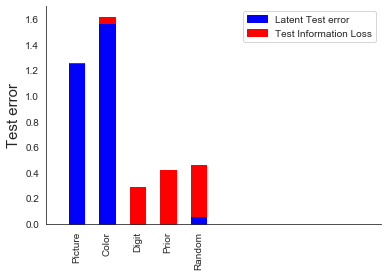

In [7]:
# Create an encoder which maps each 'x' into a latent 'z' which consists of 64 different values
encoder = DiscreteEncoder(z_dim=64)

# Define an classifier q(y|z)=p(y|z,\t=1) that is optimal on training
q_y_z = encoder(train_dist).conditional('y','z')
latent_test_dist = encoder(test_dist).marginal(['y','z','x'])
print('q(y|z)=%s' % q_y_z)

# Compute the Test error of the model q(y|z)
test_error = compute_kl(latent_test_dist, q_y_z, cond_1='x')
print('Test error: %f' % test_error)

# Compute the latent Test error of the model q(y|z)
lat_test_error = compute_kl(latent_test_dist, q_y_z, cond_1='z')
print('Latent Test error: %f' % lat_test_error)

# Compute the amount of test information loss
test_info_loss = encoder(test_dist).mi('y','x','z')
print('Test Infomation Loss: %f' % test_info_loss)


data.append({
    'Model': 'Random', 
    'Latent Test error': lat_test_error.item(), 
    'Test Information Loss': test_info_loss.item()
})


f, ax = plt.subplots(1,1)
plot_data(data, ax)
sns.despine()


The goal is to train the encoder $q(z|x)$ to minimize the Latent Test error while retaining maximal predictive information. We analyze different families of objectives in literature. Each of them present a loss in the form:
$$\mathcal{L}(\lambda) = \mathbb{E}_{t=1}[-\log q(y|z)]+ \lambda \mathcal{R}(q(z|x)),$$
in which the first term aims to maximize the amount of predictive information in the representation, while the second is a regularization term that aims to reduce the Latent Test error.
The trade-off between the two objectives is regulated by the hyper-parameter $\lambda$. Different regularization will be based on the observation of an environment variable $e$, which represents the factor(s) on which the selection is based on.

# Model Training

Here we explore the effect of training a latent representation using the following criteria:
- Independence $\mathcal{R}(q(z|x))=I(e;z)$
- Sufficiency $\mathcal{R}(q(z|x))=I(e;y|z)$
- Separation $\mathcal{R}(q(z|x))=I(e;z|y)$

## Independence Criterion

We train the model using the regularization prescribed by the independence criterion until convergence

In [8]:
from code.discrete_models.criteria import IndependenceCriterion
from code.discrete_models.training import train

# re-initialize the encoder
encoder = DiscreteEncoder(z_dim=64)

# Use the Independence criterion for training with a strong regularization $\lambda=10^6$
criterion = IndependenceCriterion(reg=1e6)

# Train until convergence, logging train and test cross entropy
logs = train(encoder, 
             criterion, 
             train_dist=train_dist.marginal(['x','y','e']), # train distribution
             test_dist=test_dist.marginal(['x','y']),       # test distribution      
             verbose=False)

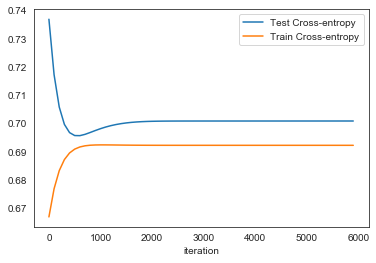

In [9]:
# Visualize the logs
pd.DataFrame(logs).plot(x='iteration')

We can compute the value of the regularization term $I(e;z)$ at the end of the training. One can notice that the independence constraint is correctly enforced on training but there is a small dependency left when considering the unselected (original) distribution.

In [10]:
# Compute the value of I(e;z) on for the trained model for the train distribution
print('I(e;z|t=1) = %f nats' % encoder(train_dist).mi('e','z'))

# Compute the value of I(e;z) on for the trained model
print('I(e;z) = %f nats' % encoder(dist).mi('e','z'))

I(e;z|t=1) = 0.000000 nats
I(e;z) = 0.004980 nats


We visualize the error compoments after convergence. Even if constraint is correctly enforced on train, the separation criterion does not result in minimal Test error

Test error: 0.424377
Latent Test error: 0.041784
Test Infomation Loss: 0.382593


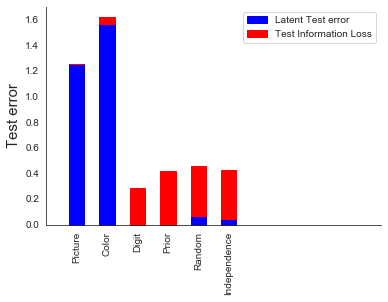

In [11]:
q_y_z = encoder(train_dist).conditional('y','z')
latent_test_dist = encoder(test_dist).marginal(['y','z','x'])

# Compute the Test error of the model q(y|z)
test_error = compute_kl(latent_test_dist, q_y_z, cond_1='x')
print('Test error: %f' % test_error)

# Compute the latent Test error of the model q(y|z)
lat_test_error = compute_kl(latent_test_dist, q_y_z, cond_1='z')
print('Latent Test error: %f' % lat_test_error)

# Compute the amount of test information loss
test_info_loss = encoder(test_dist).mi('y','x','z')
print('Test Infomation Loss: %f' % test_info_loss)

data.append({
    'Model': 'Independence', 
    'Latent Test error': lat_test_error.item(), 
    'Test Information Loss': test_info_loss.item()
})

# Plot the results
f, ax = plt.subplots(1,1)
plot_data(data, ax)
sns.despine()

## Sufficiency Criterion

We re-initialize the encoder and train it using the sufficiency criterion

In [12]:
from code.discrete_models.criteria import SufficiencyCriterion

# re-initialize the encoder
encoder = DiscreteEncoder(z_dim=64)

# Use the Sufficiency criterion for training with a strong regularization $\lambda=10^6$
criterion = SufficiencyCriterion(reg=1e6)

# Train until convergence, logging train and test cross entropy
logs = train(encoder, 
             criterion, 
             train_dist=train_dist.marginal(['x','y','e']), # train distribution
             test_dist=test_dist.marginal(['x','y']),       # test distribution      
             verbose=False)

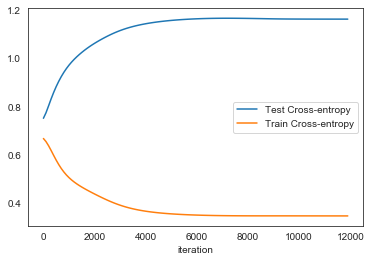

In [13]:
# Visualize the logs
pd.DataFrame(logs).plot(x='iteration')

Note that despite the long training, the model is not able to create a representation that satisfies the sufficiency constraint $ I(e;y|z)=0 $ on training (such representation does not exist for the d-CMNIST dataset

In [14]:
# Compute the value of I(e;z) on for the trained model for the train distribution
print('I(e;y|z, t=1) = %f' % encoder(train_dist).mi('e','y','z'))

# Compute the value of I(e;z) on for the trained model
print('I(e;y|z) = %f' % encoder(dist).mi('e','y','z'))

I(e;y|z, t=1) = 0.034149
I(e;y|z) = 0.133104


Once again the resulting model is not optimal in terms of Test error

Test error: 0.888159
Latent Test error: 0.506268
Test Infomation Loss: 0.381891


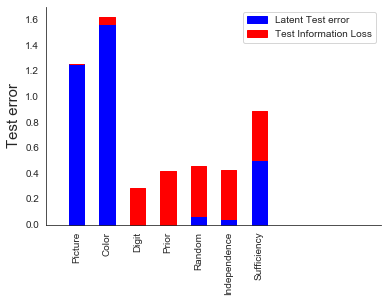

In [15]:
q_y_z = encoder(train_dist).conditional('y','z')
latent_test_dist = encoder(test_dist).marginal(['y','z','x'])

# Compute the Test error of the model q(y|z)
test_error = compute_kl(latent_test_dist, q_y_z, cond_1='x')
print('Test error: %f' % test_error)

# Compute the latent Test error of the model q(y|z)
lat_test_error = compute_kl(latent_test_dist, q_y_z, cond_1='z')
print('Latent Test error: %f' % lat_test_error)

# Compute the amount of test information loss
test_info_loss = encoder(test_dist).mi('y','x','z')
print('Test Infomation Loss: %f' % test_info_loss)

data.append({
    'Model': 'Sufficiency', 
    'Latent Test error': lat_test_error.item(), 
    'Test Information Loss': test_info_loss.item()
})

# Plot the results
f, ax = plt.subplots(1,1)
plot_data(data, ax)
sns.despine()

## Separation Criterion

We repeat the same procedure by applying the separation criterion instead

In [16]:
from code.discrete_models.criteria import SeparationCriterion

# re-initialize the encoder
encoder = DiscreteEncoder(z_dim=64)

# Use the Sufficiency criterion for training with a strong regularization $\lambda=10^6$
criterion = SeparationCriterion(reg=1e6)

# Train until convergence, logging train and test cross entropy
logs = train(encoder, 
             criterion, 
             train_dist=train_dist.marginal(['x','y','e']), # train distribution
             test_dist=test_dist.marginal(['x','y']),       # test distribution      
             verbose=False)

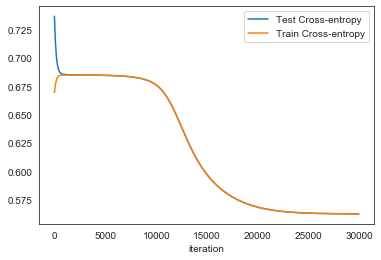

In [17]:
# Visualize the logs
pd.DataFrame(logs).plot(x='iteration')

Once again, we check if the model manages to enforce the separation constraint $I(e;z|y)=0$ for the overall (unselected) distribution

In [18]:
# Compute the value of I(e;z) on for the trained model for the train distribution
print('I(e;z|y, t=1) = %f' % encoder(train_dist).mi('e','z','y'))

# Compute the value of I(e;z) on for the trained model
print('I(e;z|y) = %f' % encoder(dist).mi('e','z','y'))

I(e;z|y, t=1) = 0.000000
I(e;z|y) = -0.000000


The model that enforces the separation criterion is the only one that minimizes the overall OOD error on the y-CMNIST dataset

Test error: 0.285903
Latent Test error: 0.000000
Test Infomation Loss: 0.285903


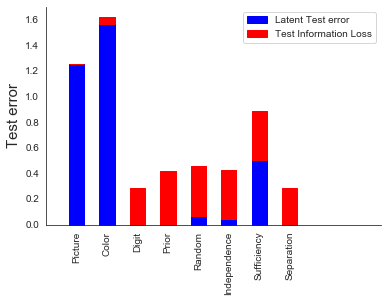

In [19]:
q_y_z = encoder(train_dist).conditional('y','z')
latent_test_dist = encoder(test_dist).marginal(['y','z','x'])

# Compute the Test error of the model q(y|z)
test_error = compute_kl(latent_test_dist, q_y_z, cond_1='x')
print('Test error: %f' % test_error)

# Compute the latent Test error of the model q(y|z)
lat_test_error = compute_kl(latent_test_dist, q_y_z, cond_1='z')
print('Latent Test error: %f' % lat_test_error)

# Compute the amount of test information loss
test_info_loss = encoder(test_dist).mi('y','x','z')
print('Test Infomation Loss: %f' % test_info_loss)



data.append({
    'Model': 'Separation', 
    'Latent Test error': lat_test_error.item(), 
    'Test Information Loss': test_info_loss.item()
})

# Plot the results
f, ax = plt.subplots(1,1)
plot_data(data, ax)
sns.despine()

The other experiments reported in the paper can be repliated by changing the data-generating distribution reported at the beginning of this notebook. The `train_discrete.py` training script used to produce the trajectories shown in the paper. Here we show the trajectories obtained by training with different values of $\lambda$

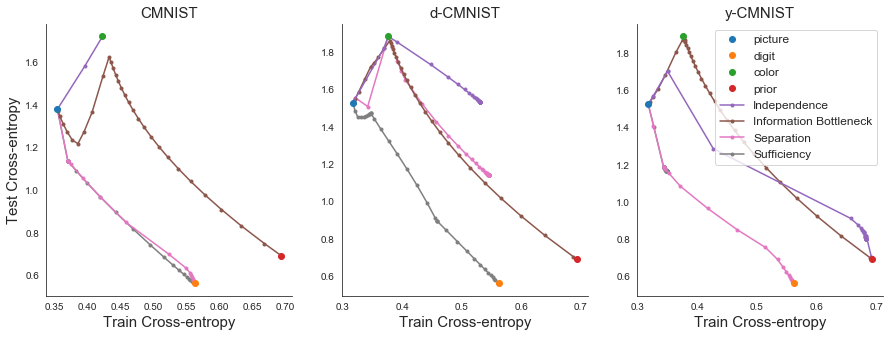

In [22]:
# Create the axis for plotting
f, ax = plt.subplots(1,3, figsize=(15,5))

# Load the data from files
disc_data = pd.read_csv('results/trajectories.csv')
th_data = pd.read_csv('results/points.csv')  
    
# Plot the points corresponding to models using picture, digit, color or prior information
for i, (dataset, dataset_data) in enumerate(th_data.groupby('dataset')):
    for _, entry in dataset_data.iterrows():
        ax[i].plot(
            entry['CrossEntropy(T=1)'],
            entry['CrossEntropy(T=0)'], 
            'o',
            label = entry['name']
        )
    ax[i].set_xlabel('Train Cross-entropy', fontsize=15)
    
        
# Plot the trajectories obtained using different values of lambda for the different criteria        
for i, (dataset_name, dataset_results) in enumerate(disc_data.groupby('dataset')):
    ax[i].set_title(dataset_name, size=15)
    for j, (criterion_name, criterion_data) in enumerate(dataset_results.groupby('criterion')):
        ax[i].plot(criterion_data['CrossEntropy(t=1)'], 
                   criterion_data['CrossEntropy(t=0)'], 
                   '.-', label=criterion_name, zorder=-j)
        


ax[0].set_ylabel('Test Cross-entropy', fontsize=15)
ax[-1].legend(fontsize=12)
sns.despine()